In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.dpi'] = 125
plt.rcParams['figure.facecolor'] = 'white'

import numpy as np

import obspy
from obspy import read, UTCDateTime, Stream, Trace

import xarray as xr
import pandas as pd

import scipy
from scipy.signal import spectrogram as sp
from scipy.signal import welch 

import os
import sys  
# module_path = os.path.abspath(os.path.join('/Users/gilaverbuch/dev/SignalProcessing/pyoad'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
# from src.pyoad.pyoad import read_data, save2mseed

# import webbrowser 
# import dask
# from dask import delayed, compute
# from dask.distributed import Client, LocalCluster


# cluster = LocalCluster(n_workers=3, threads_per_worker=2)
# client_dask = Client(cluster)
# webbrowser.open(client_dask.dashboard_link, new=2)

# Problem geometry

Two-layer liquid half space. Layer 1 (0<z<D) has a speed of sound c1. Layer 2 (z>D) has a speed of sound c2. Both source and receiver ar placed within the first layer. c2>c1. 

--------------------------------------------------------------------------------- z=0, pressure release surface

c1


*(0, z_s)




                                                           *(r,z)

--------------------------------------------------------------------------------- z=D, continuitu of P and w

c2

In [120]:
c0 = 1500 #reference velocity
c1 = 1500 # layer 1 velocity
c2 = 2000 # layer 2 velocity
d  = 1000 # depth of layer 1

omega = 2*np.pi*5 #angular frequency
k0 = omega/c0 # reference wavenumber
k1 = c0/c1 # dimentionless wavenumber layer 1
k2 = c0/c2 # dimentionless wavenumber layer 2
dq = (k1-k2)/1e4 # horizontal dimentionless wavenumber resolution 
q = np.arange(k2, k1, dq) # horizontal dimentionless wavenumber
mu1 = np.sqrt(k1**2 - q**2) # dimentionless vertical wavenumber layer 1
mu2_abs = np.sqrt((q**2 - k2**2)) # dimentionless vertical wavenumber layer 2
mu2 = 1j*mu2_abs
mu_func = -mu2_abs/mu1 
cot_func = 1/np.tan(k0*mu1*d)
idx = np.argwhere(np.diff(np.sign(mu_func - cot_func))).flatten()  #index of functions intersections (modes)

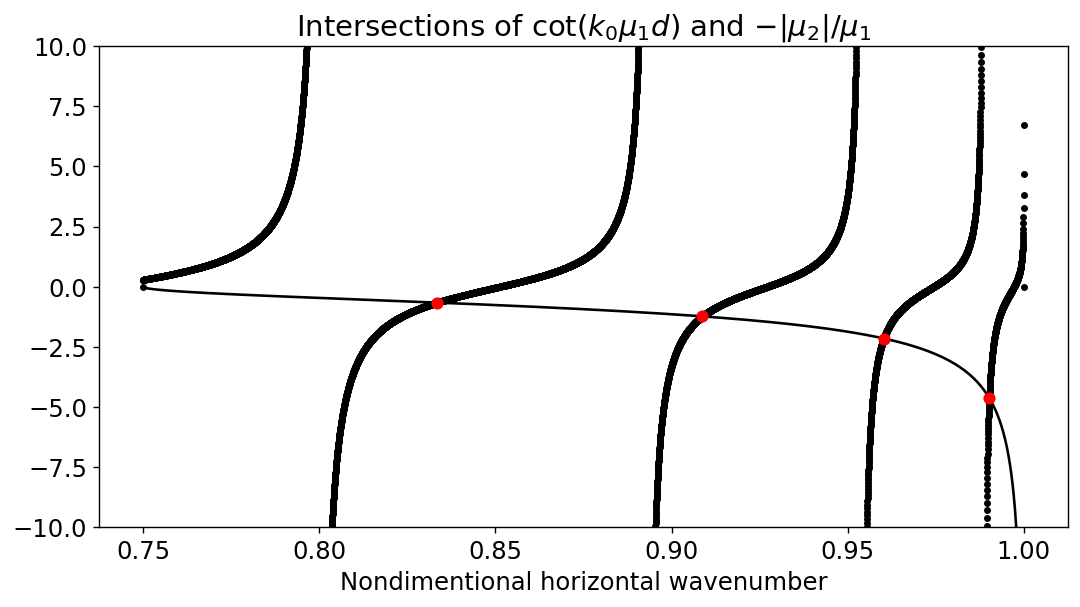

In [133]:

plt.figure(figsize = (10,5))
plt.plot(k1, 0, 'k.')
plt.plot(k2, 0, 'k.')
plt.plot(q, mu_func, 'k')
plt.plot(q, cot_func, 'k.')
plt.plot(q[idx], cot_func[idx], 'ro')
plt.ylim(-10,10)
plt.title('Intersections of $\cot (k_0 \mu_1 d)$ and $-|\mu_2|/\mu_1$')
plt.xlabel('Nondimentional horizontal wavenumber')
plt.show()

In [111]:
q[idx]

array([0.76575, 0.8    , 0.81825, 0.851  , 0.8635 , 0.893  , 0.90125,
       0.927  , 0.93225, 0.95375, 0.95725, 0.97425, 0.976  , 0.9885 ,
       0.98925, 0.997  , 0.99725])